In [1]:
import requests
import json
import pandas as pd
from collections import deque
import numpy as np
import re
from google.colab import files

# Coronavirus data extraction pipeline

### Direct Acyclic Graph 

In [2]:
class DAG():
    def __init__(self):
        self.graph = {}

    def add(self, node, to=None):
        if not node in self.graph:
            self.graph[node] = []
        if to:
            if not to in self.graph:
                self.graph[to] = []
            self.graph[node].append(to)

        if(len(self.sort())>len(self.graph)):
            raise Exception

    def in_degrees(self):
      self.degrees={}
      for node in self.graph:
        if node not in self.degrees:
          self.degrees[node]=0

        for directed in self.graph[node]:
          if directed not in self.degrees:
            self.degrees[directed]=0
          self.degrees[directed]+=1


    def sort(self):
        que=deque()
        searched=[]
        self.in_degrees()
        for i in self.graph:
            if(self.degrees[i]==0):
                que.append(i)

        while (len(que)>0):
          i=que.popleft()
          temp=self.graph[i]
          
          for j in temp:
              self.degrees[j]-=1
              if(self.degrees[j]==0):
                  que.append(j)
                  
          searched.append(i)
          self.final=searched[len(searched)-1]
        return searched


### Pipeline

In [3]:
class Pipeline():
    def __init__(self):
        self.tasks = DAG()
        self.output=[]

    def task(self, depends_on=None,output=False):
        def inner(f):
            self.tasks.add(f)
            if (output):
              self.output.append(f)            
            if depends_on:
                self.tasks.add(depends_on, f)
            return f
        return inner
    
    def run(self):
        visited=self.tasks.sort()
        self.result={}
        self.completed={}
        count=1
        for task in visited:
            for node,depends in self.tasks.graph.items():


                if task in depends:
                    self.completed[task]=task(self.completed[node])
            if task not in self.completed:
                self.completed[task]=task()
        for task in self.output:
            self.result[count]=self.completed[task]
            count+=1
        return self.result
        

Using decorators to connect insert functions into pipeline

In [4]:
pipeline = Pipeline()
pipe = Pipeline()

@pipeline.task()
def extract_data():
  response=requests.get("https://covidtracking.com/api/v1/states/daily.json")  # Api
  json_data=response.json()
  data=pd.json_normalize(json_data)

  return data

@pipeline.task(depends_on=extract_data,output=True)
def useless_remove(raw):
  useless=["dataQualityGrade","lastUpdateEt","dateModified","checkTimeEt","dateChecked","hash","pending","inIcuCumulative","onVentilatorCumulative","positiveTestsViral","negativeTestsViral","positiveCasesViral","totalTestsViral","hospitalized","hospitalizedCumulative","fips"]
  deprecated=["total","totalTestResults","totalTestResultsIncrease","positiveIncrease","posNeg","negativeIncrease","hospitalizedIncrease","deathIncrease","commercialScore","negativeRegularScore","negativeScore","positiveScore","score","deathConfirmed","deathProbable"]
  raw=raw.drop(useless,axis=1)
  raw=raw.drop(deprecated,axis=1)
  raw=raw.drop(["recovered","grade"],axis=1)
  raw['date']=raw.apply(lambda x: pd.to_datetime(x['date'], format='%Y%m%d', errors='ignore'),axis=1)
  return raw


def backfill_state(cleaned):
  data=pd.DataFrame(columns=cleaned.columns)
  for val in cleaned.state.unique():
    state=cleaned[cleaned['state']==val].sort_values(by='date')
    state[['hospitalizedCurrently','inIcuCurrently','onVentilatorCurrently','death']]=state[['hospitalizedCurrently','inIcuCurrently','onVentilatorCurrently','death']].fillna(method='bfill')

    data=data.append(state,ignore_index=True)
  return data

@pipeline.task(depends_on=useless_remove,output=True)
def icu_states(data):
  df=pd.DataFrame(columns=data.columns)
  for val in data.state.unique():
    state=data[data['state']==val]
    if (state.isnull().sum()/len(state))['inIcuCurrently']<0.3:
      df=df.append(state,ignore_index=True)
  df=df.drop(["hospitalizedCurrently","onVentilatorCurrently"],axis=1)
  return df

@pipeline.task(depends_on=useless_remove,output=True)
def hosp_states(data):
  df=pd.DataFrame(columns=data.columns)
  for val in data.state.unique():
    state=data[data['state']==val]
    if (state.isnull().sum()/len(state))["hospitalizedCurrently"]<0.3:
      df=df.append(state,ignore_index=True)
  df=df.drop(["inIcuCurrently","onVentilatorCurrently"],axis=1)
  return df

@pipeline.task(depends_on=useless_remove,output=True)
def vent_states(data):
  df=pd.DataFrame(columns=data.columns)
  for val in data.state.unique():
    state=data[data['state']==val]
    if (state.isnull().sum()/len(state))['onVentilatorCurrently']<0.3:
      df=df.append(state,ignore_index=True)
  df=df.drop(["inIcuCurrently","hospitalizedCurrently"],axis=1)
  return df

outputs=pipeline.run()


Plotting function

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_state(df,out):
  fig = plt.figure(figsize=(16, 16))
  count=0
  n=len(df.state.unique())
  for val in df.state.unique():
    ax = fig.add_subplot(math.ceil(n/5),5,count+1)
    state=df[df['state']==val].sort_values(by='date')
    state[[out]]=state[[out]].fillna(method='bfill')

    ax.plot(state['date'],state[out])
    
    for key,spine in ax.spines.items():
      spine.set_visible(False)
    ax.set_title(val)
    plt.xticks(rotation=90)
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    count+=1
    ax.axes.get_xaxis().set_visible(False)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


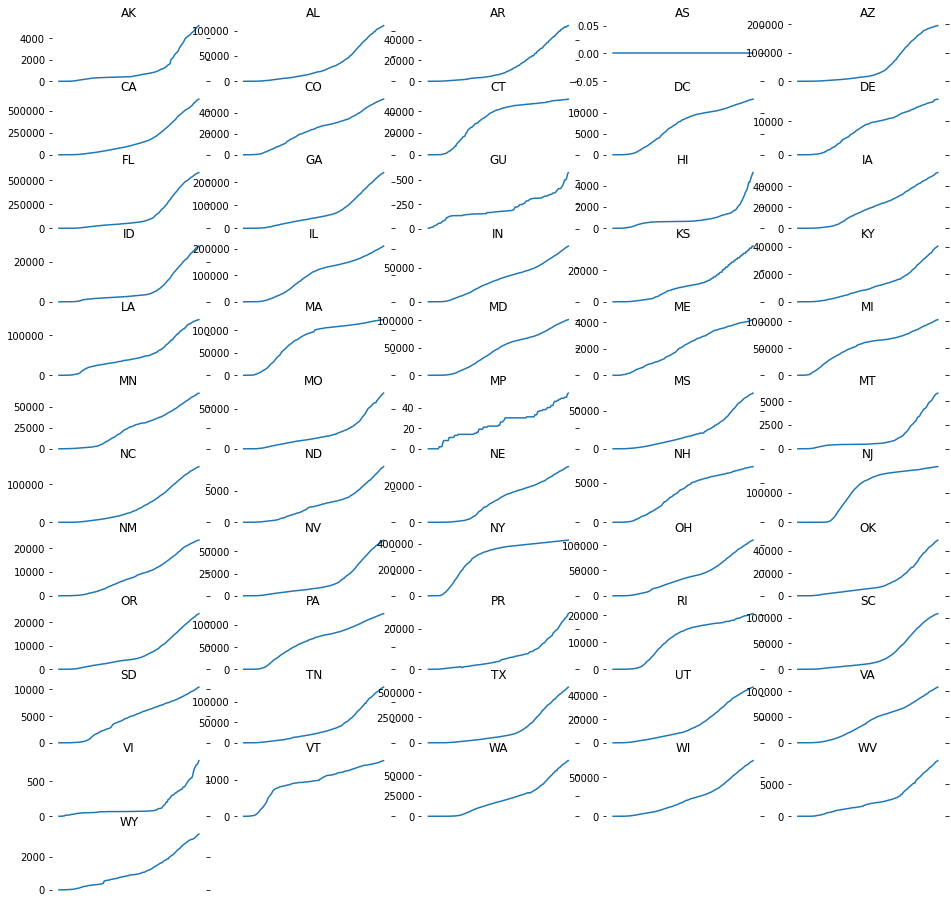

In [6]:
plot_state(outputs[1],"positive")

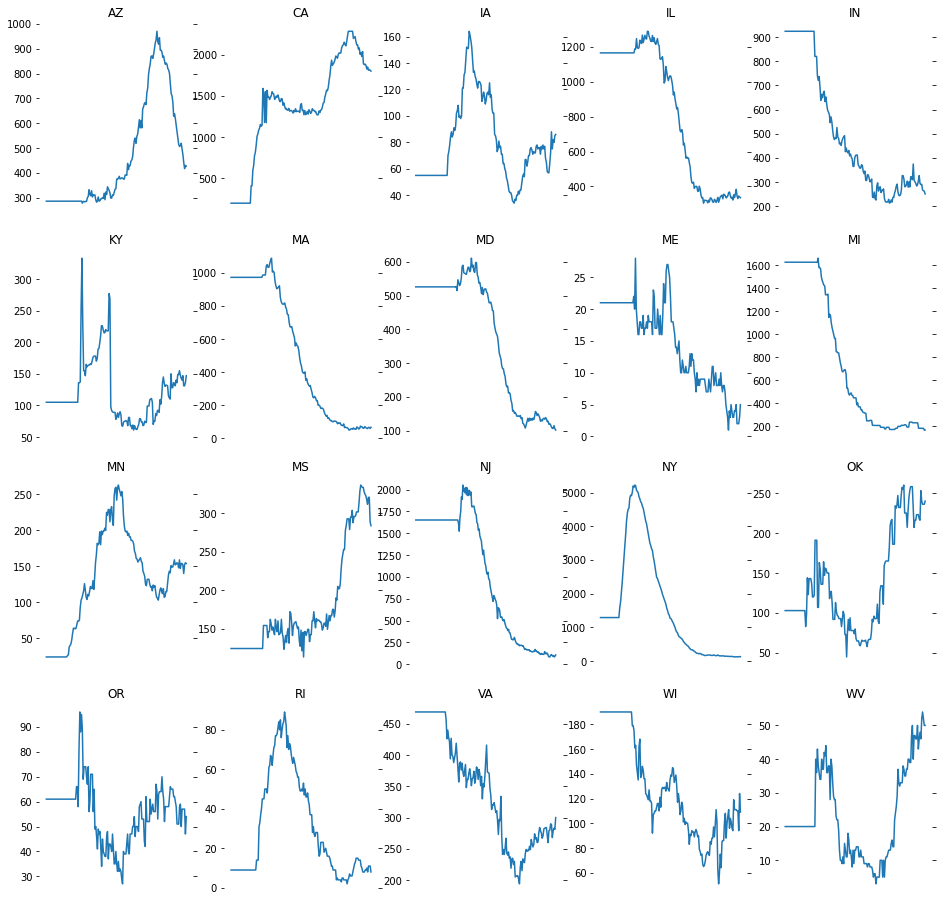

In [7]:
plot_state(outputs[2],"inIcuCurrently")


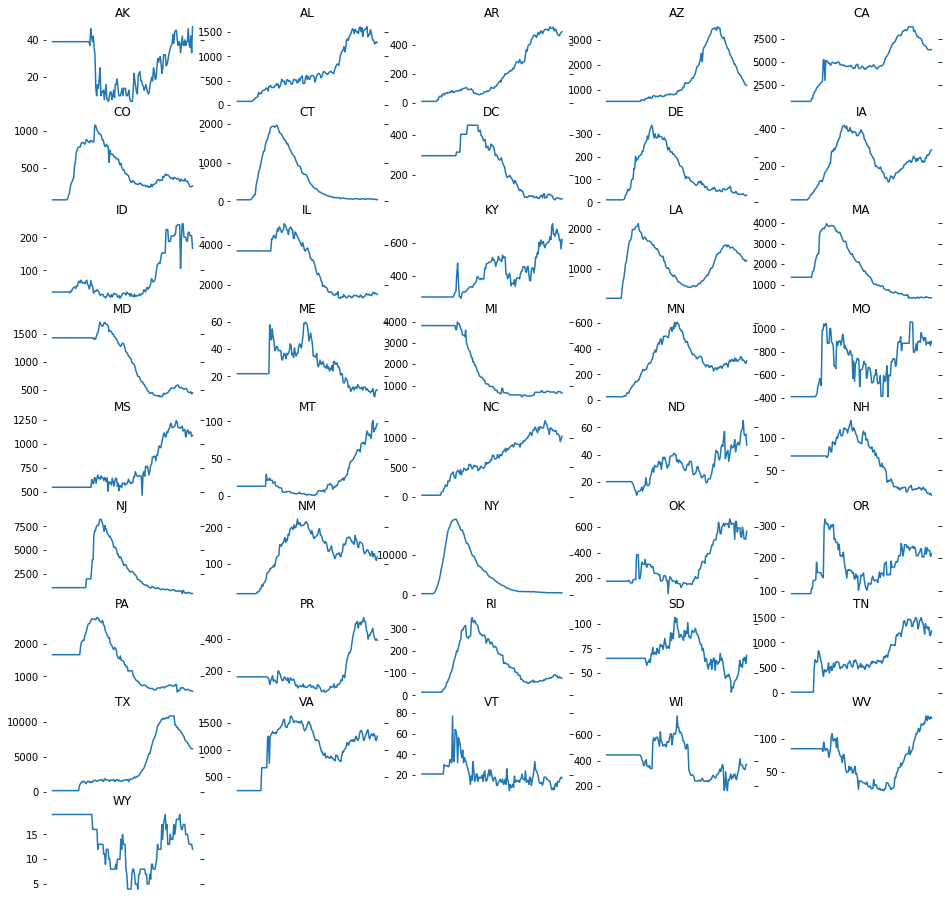

In [8]:
plot_state(outputs[3],'hospitalizedCurrently')


Extracting output data

In [9]:
basic=outputs[1].drop(['hospitalizedCurrently',
       'inIcuCurrently', 'onVentilatorCurrently'],axis=1)
basic=basic.dropna()
# basic.to_csv('basic.csv',index=False)
# files.download('basic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
icu=outputs[2]
icu=icu.drop(['negative','death'],axis=1)
icu=icu.dropna()
# icu.to_csv('icu.csv',index=False)
# files.download('icu.csv')

In [11]:
hosp=outputs[3].drop(['negative','death'],axis=1)
hosp=hosp.dropna()
#hosp.to_csv('hospitalized.csv',index=False)
#files.download('hospitalized.csv')

In [12]:
vent=outputs[4].drop(['negative','death'],axis=1)
vent=vent.dropna()
#vent.to_csv('ventilator.csv',index=False)
#files.download('ventilator.csv')

#Protest Data from [Countlove](https://countlove.org/statistics.html) 

In [14]:
protest_data=pd.read_csv('/content/protests.csv')
protest_data.head()

,Date,Location,Attendees,Event (legacy; see tags),Tags,Curated,Source,Total Articles
0,2017-01-15,"Bowie State University, Bowie, MD",1500.0,Healthcare,Healthcare; For Affordable Care Act,Yes,http://www.capitalgazette.com/news/ph-ac-cn-ac...,1
1,2017-01-16,"Johnson City, TN",300.0,Civil Rights,Civil Rights; For racial justice; Martin Luthe...,Yes,http://www.johnsoncitypress.com/Local/2017/01/...,4
2,2017-01-16,"Indianapolis, IN",20.0,Environment,Environment; For wilderness preservation,Yes,http://wishtv.com/2017/01/16/nature-groups-pro...,1
3,2017-01-16,"Cincinnati, OH",NaN,Other (Martin Luther King Jr.),Civil Rights; For racial justice; Martin Luthe...,Yes,http://www.cincinnati.com/picture-gallery/news...,1
4,2017-01-18,"Hartford, CT",300.0,Healthcare (Pro-Planned Parenthood),Healthcare; For Planned Parenthood,Yes,http://www.realhartford.org/2017/01/19/reprodu...,1


In [15]:
protest_data['state']=protest_data['Location'].apply(lambda x:x.split(',')[-1]).str.strip()
protest_data['state']

0        MD
1        TN
2        IN
3        OH
4        CT
         ..
30036    FL
30037    MI
30038    WA
30039    NY
30040    NY
Name: state, Length: 30041, dtype: object

In [16]:
protest_data.isnull().sum()/len(protest_data)

Date                        0.000000
Location                    0.000000
Attendees                   0.367132
Event (legacy; see tags)    0.000000
Tags                        0.000000
Curated                     0.000000
Source                      0.000000
Total Articles              0.000000
state                       0.000000
dtype: float64

In [17]:
protest_data=protest_data.dropna()
protest_data=protest_data.drop(['Location','Tags','Curated','Source','Total Articles'],axis=1)

In [18]:
protest_data['Event']=protest_data['Event (legacy; see tags)'].apply(lambda x:x.split()[0])
protest_data=protest_data.drop(['Event (legacy; see tags)'],axis=1)

In [19]:
# protest_data.to_csv('protest.csv',index=False)
# files.download('protest.csv')

In [20]:
protest_data[protest_data['Attendees']==protest_data['Attendees'].max()]

,Date,Attendees,state,Event
30,2017-01-21,725000.0,DC,Civil


In [21]:
protest_data['state']=protest_data['state'].apply(lambda x: x.upper())

In [22]:
state=protest_data[['Attendees','state']]
state=state.groupby(['state']).sum().sort_values('Attendees')
# state.to_csv('grouped.csv')
# files.download('grouped.csv')


In [23]:
protest_data['state'].value_counts()

CA                                        2236
NY                                        1305
FL                                         937
PA                                         904
TX                                         805
MA                                         696
MI                                         684
WA                                         647
IL                                         593
NC                                         554
OR                                         543
OH                                         523
NJ                                         487
VA                                         470
CO                                         407
IN                                         404
MN                                         374
CT                                         362
MO                                         353
WI                                         351
TN                                         311
KY           

In [24]:
blm=protest_data[protest_data['Event']=='Racial']
blm=blm[['Attendees','state']]
blm=blm.groupby(['state']).sum().sort_values('Attendees')
blm.to_csv('blm.csv')
files.download('blm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#GDP data from Wikipedia

In [26]:
gdp=pd.read_csv('/content/US_GDP.txt',header=None,delimiter='\t',names=['Rank','State','GDP','Percent','GDP Per Cap','Region'])

In [27]:

gdp['GDP Per Cap']=gdp['GDP Per Cap'].apply(lambda x: re.sub('\[[A-Z0-9]*\]', "",str(x)))
gdp['Percent']=gdp['Percent'].apply(lambda x: re.sub('\[[A-Z0-9]*\]', "",str(x)))
gdp['Region']=gdp['Region'].apply(lambda x: re.sub('\[[A-Z0-9]*\]', "",str(x)))

In [28]:
state_map={'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA','Colorado':'CO','Connecticut':'CT','Delaware':'DE','Florida':'FL',
'Georgia':'GA',
'Hawaii':'HI',
'Idaho':'ID',
'Illinois':'IL',
'Indiana':'IN',
'Iowa':'IA',
'Kansas':'KS',
'Kentucky':'KY',
'Louisiana':'LA',
'Maine':'ME',
'Maryland':'MD',
'Massachusetts':'MA',
'Michigan':'MI',
'Minnesota':'MN',
'Mississippi':'MS',
'Missouri':'MO',
'Montana':'MT',
'Nebraska':'NE',
'Nevada':'NV',
'New Hampshire':'NH',
'New Jersey':'NJ',
'New Mexico':'NM',
'New York':'NY',
'North Carolina':'NC',
'North Dakota':'ND',
'Ohio':'OH',
'Oklahoma':'OK',
'Oregon':'OR',
'Pennsylvania':'PA',
'Rhode Island':'RI',
'South Carolina':'SC',
'South Dakota':'SD',
'Tennessee':'TN',
'Texas':'TX',
'Utah':'UT',
'Vermont':'VT',
'Virginia':'VA',
'Washington':'WA',
'West Virginia':'WV',
'Wisconsin':'WI',
'Wyoming':'WY','Puerto Rico':'PR','Guam':'Gu','U.S. Virgin Islands':'VI','Northern Mariana Islands':'NMI','American Samoa':'AS','District of Columbia':'COL'}

In [29]:
gdp['State']=gdp['State'].apply(lambda x: re.sub('^[ \t]+|[ \t]+$','',x))
gdp['State_abb']=gdp['State'].map(state_map)

In [30]:
# gdp.to_csv('gdp.csv',index=False)
# files.download('gdp.csv')

#US population data from Wikipedia

In [31]:
pop=pd.read_csv('US_pop.txt',header=None,delimiter='\t',names=['ind','State','Population','Percent'])
pop.head()

,ind,State,Population,Percent
0,1,California,"39,512,223",11.91%
1,2,Texas,"28,995,881",8.74%
2,3,Florida,"21,477,737",6.47%
3,4,New York,"19,453,561",5.86%
4,5,Illinois,"12,671,821",3.86%


In [32]:
pop=pop.drop(['ind'],axis=1)
pop['Population']=pop['Population'].apply(lambda x: int(re.sub(',','',x)))
pop['Percent']=pop['Percent'].apply(lambda x: float(re.sub('%','',x)))
pop['State_abb']=pop['State'].map(state_map)

In [33]:
pop.head()

,State,Population,Percent,State_abb
0,California,39512223,11.91,CA
1,Texas,28995881,8.74,TX
2,Florida,21477737,6.47,FL
3,New York,19453561,5.86,NY
4,Illinois,12671821,3.86,IL


In [34]:
# pop.to_csv('pop.csv',index=False)
# files.download('pop.csv')